# Bollinger Bands Backtest with Tick Data

This notebook implements a high-performance Bollinger Bands trading strategy using tick-level data for realistic execution simulation.

## Strategy Overview
- **Entry Signal**: Long when close < lower band, Short when close > upper band
- **Exit Signal**: Close position when price reaches middle band
- **Position Limit**: Maximum 1 position at a time
- **Execution**: Realistic tick-level execution with bid/ask spread

## Data Processing
1. Load tick data (bid/ask prices with timestamps)
2. Resample to 1-minute OHLC for indicator calculation
3. Calculate Bollinger Bands on 1-minute data
4. Map signals back to tick data for execution
5. Execute strategy with numba optimization

## 📋 Configuration Parameters

Modify these parameters to easily test different configurations without changing code throughout the notebook.

In [1]:
# ========================================
# 📋 GLOBAL CONFIGURATION PARAMETERS
# ========================================

# 📁 Data Configuration
TICK_DATA_PATH = '/home/edocame/Desktop/data_python/nzdjpy_2monthTick.csv'

# 📊 Bollinger Bands Strategy Parameters
BB_WINDOW = 1000        # Period for Bollinger Bands calculation (minutes) - Default: 1440 (24h)
BB_STD = 1           # Number of standard deviations for bands - Default: 1.0
BB_PRICE_COL = 'close' # Price column to use for BB calculation

# 🎯 Trading Strategy Parameters
MAX_POSITION_SIZE = 1   # Maximum number of concurrent positions
INITIAL_CAPITAL = 10000 # Starting capital for performance metrics

# 📈 Performance Analysis Parameters
PLOT_FIGURES_SIZE = (15, 10)           # Default figure size for plots
REGRESSION_FIGURES_SIZE = (16, 12)     # Figure size for regression analysis

# 🔧 Technical Parameters
RANDOM_SEED = 42        # For reproducible results
WARNING_SUPPRESS = True # Suppress pandas/numpy warnings

print("✅ Configuration parameters loaded:")
print(f"📁 Tick Data Path: {TICK_DATA_PATH}")
print(f"📊 BB Window: {BB_WINDOW} periods")
print(f"📊 BB Standard Deviation: {BB_STD}")
print(f"💰 Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"🎯 Max Position Size: {MAX_POSITION_SIZE}")
print("=" * 50)

✅ Configuration parameters loaded:
📁 Tick Data Path: /home/edocame/Desktop/data_python/nzdjpy_2monthTick.csv
📊 BB Window: 1000 periods
📊 BB Standard Deviation: 1
💰 Initial Capital: $10,000
🎯 Max Position Size: 1


In [2]:
import backtrader as bt
import pandas as pd
import numpy as np
import numba as nb
from numba import jit
import warnings
import time

# Apply configuration settings
if WARNING_SUPPRESS:
    warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")
print(f"📁 Using data path: {TICK_DATA_PATH}")
print(f"⚙️ Random seed set to: {RANDOM_SEED}")

✅ Libraries imported successfully
📁 Using data path: /home/edocame/Desktop/data_python/nzdjpy_2monthTick.csv
⚙️ Random seed set to: 42


## 2. Core Functions

In [3]:
def calculate_bollinger_bands(df, price_col=BB_PRICE_COL, window=BB_WINDOW, num_std=BB_STD):
    """Calculate Bollinger Bands using global configuration parameters"""
    df['middle_band'] = df[price_col].rolling(window).mean()
    std = df[price_col].rolling(window).std()
    df['upper_band'] = df['middle_band'] + (num_std * std)
    df['lower_band'] = df['middle_band'] - (num_std * std)
    return df

In [4]:
@jit(nopython=True)
def bollinger_strategy_numeric(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands):
    """CORRECTED Numba-optimized Bollinger Bands strategy - fixes timing and spread issues"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        # CORRECTED: Use current close/bands for current tick signals (no look-ahead)
        current_close = close_prices[i]
        current_upper = upper_bands[i]
        current_middle = middle_bands[i]
        current_lower = lower_bands[i]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                # CORRECTED EXIT LOGIC: Realistic spread handling
                if position == 1:  # Long position - sell at bid
                    exit_price = current_bid
                    pnl = exit_price - entry_price  # positive if profitable
                else:  # Short position - buy at ask
                    exit_price = current_ask
                    pnl = entry_price - exit_price  # positive if profitable
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position - CORRECTED ENTRY LOGIC
        if position == 0:
            if current_close < current_lower:  # BUY signal
                position = 1
                entry_price = current_ask  # Buy at ask price (pay spread)
                entry_idx = i
            elif current_close > current_upper:  # SELL signal
                position = -1
                entry_price = current_bid  # Sell at bid price (pay spread)
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

In [5]:
@jit(nopython=True)
def bollinger_strategy_full_equity(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands, initial_capital):
    """CORRECTED Numba-optimized Bollinger Bands strategy with full equity position sizing"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    position_sizes = np.zeros(max_trades, dtype=np.float64)
    equities = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    current_equity = initial_capital
    position_size = 0.0
    
    for i in range(1, n):
        # CORRECTED: Use current close/bands for current tick signals (no look-ahead)
        current_close = close_prices[i]
        current_upper = upper_bands[i]
        current_middle = middle_bands[i]
        current_lower = lower_bands[i]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                # CORRECTED EXIT LOGIC with position sizing
                if position == 1:  # Long position - sell at bid
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * position_size
                else:  # Short position - buy at ask
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * position_size
                
                # Update equity
                current_equity += pnl
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    position_sizes[trade_count] = position_size
                    equities[trade_count] = current_equity
                    trade_count += 1
                
                position = 0
                position_size = 0.0
        
        # Open new position using 100% of available equity - CORRECTED ENTRY LOGIC
        if position == 0 and current_equity > 0:
            if current_close < current_lower:  # BUY signal
                position = 1
                entry_price = current_ask  # Buy at ask (pay spread)
                position_size = current_equity / current_ask  # Use all equity
                entry_idx = i
            elif current_close > current_upper:  # SELL signal
                position = -1
                entry_price = current_bid  # Sell at bid (pay spread)
                position_size = current_equity / current_bid  # Use all equity equivalent
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count],
            position_sizes[:trade_count], equities[:trade_count])

In [6]:
def run_full_equity_bollinger_backtest(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD, initial_capital=INITIAL_CAPITAL):
    """Ultra-fast Bollinger Bands backtest with full equity position sizing"""
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy with full equity
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls, position_sizes, equities = bollinger_strategy_full_equity(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values,
        initial_capital
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls,
            'position_size': position_sizes,
            'equity_after_trade': equities
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return_pct'] = trades_df['pnl'] / (trades_df['equity_after_trade'] - trades_df['pnl']) * 100
        return trades_df, df_1min
    
    return None, df_1min

## 3. Ultra-Fast Backtest Implementation

This section contains the optimized numba-accelerated trading strategy and backtesting engine.

In [7]:
# Execute backtest using global configuration with full equity positioning
start_time = time.time()
trades_df_fast, df_1min_fast = run_full_equity_bollinger_backtest()
execution_time = time.time() - start_time

# Show results
if trades_df_fast is not None:
    print(f"🚀 Backtest completed in {execution_time:.2f}s")
    print(f"📊 Strategy Configuration:")
    print(f"   📊 BB Window: {BB_WINDOW} periods")
    print(f"   📊 BB Std Dev: {BB_STD}")
    print(f"   📁 Data: {TICK_DATA_PATH.split('/')[-1]}")
    print(f"   💰 Initial Capital: ${INITIAL_CAPITAL:,}")
    print("=" * 50)
    print(f"📊 Trades: {len(trades_df_fast)}")
    print(f"💰 Total PnL: ${trades_df_fast['pnl'].sum():.2f}")
    print(f"📈 Total Return: {((trades_df_fast['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100:.2f}%")
    print(f"📈 Win Rate: {(trades_df_fast['pnl'] > 0).mean():.1%}")
    print(f"⏱️ Avg Duration: {trades_df_fast['duration'].mean()}")
    print(f"📊 Final Equity: ${trades_df_fast['equity_after_trade'].iloc[-1]:,.2f}")
    print(f"📊 Avg Return per Trade: {trades_df_fast['return_pct'].mean():.3f}%")
else:
    print("❌ No trades executed")

🚀 Backtest completed in 4.75s
📊 Strategy Configuration:
   📊 BB Window: 1000 periods
   📊 BB Std Dev: 1
   📁 Data: nzdjpy_2monthTick.csv
   💰 Initial Capital: $10,000
📊 Trades: 118
💰 Total PnL: $-1071.03
📈 Total Return: -10.71%
📈 Win Rate: 50.8%
⏱️ Avg Duration: 0 days 08:48:17.118644067
📊 Final Equity: $8,928.97
📊 Avg Return per Trade: -0.096%


## 5. Performance Visualization

Let's create an equity curve and other performance visualizations to better understand the strategy behavior.

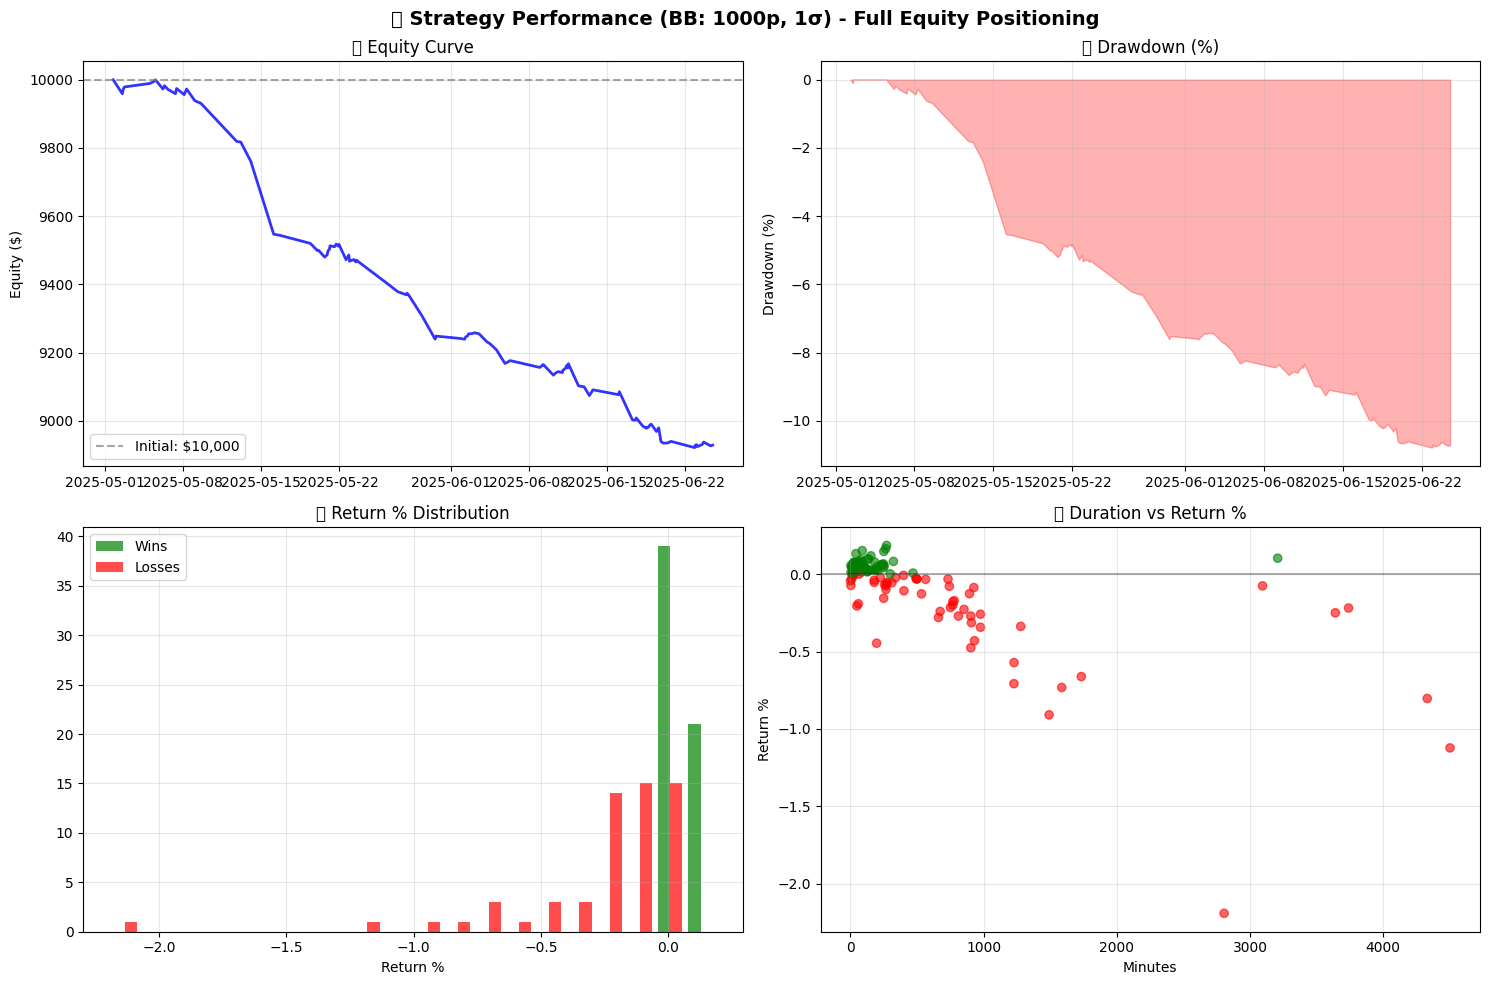

📈 Total Return: -10.71%
📉 Max Drawdown: -10.78%
🎯 Win Rate: 50.8%
📊 Avg Return per Trade: -0.096%
💰 Final Equity: $8,928.97
📊 Sharpe (return %): -0.321


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(trades_df, initial_capital=INITIAL_CAPITAL):
    """Create performance dashboard using global configuration with proper equity curve"""
    if trades_df is None:
        print("❌ No trades to plot")
        return
    
    # Calculate proper equity curve using the equity_after_trade column
    trades_df = trades_df.copy()
    
    # Create equity curve that starts from initial capital
    equity_curve = [initial_capital]
    equity_curve.extend(trades_df['equity_after_trade'].tolist())
    
    # Create timestamps for equity curve
    time_curve = [trades_df['entry_time'].iloc[0]]
    time_curve.extend(trades_df['exit_time'].tolist())
    
    trades_df['equity'] = trades_df['equity_after_trade']
    trades_df['running_max'] = trades_df['equity'].expanding().max()
    trades_df['drawdown'] = (trades_df['equity'] - trades_df['running_max']) / trades_df['running_max'] * 100
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=PLOT_FIGURES_SIZE)
    fig.suptitle(f'🚀 Strategy Performance (BB: {BB_WINDOW}p, {BB_STD}σ) - Full Equity Positioning', fontsize=14, fontweight='bold')
    
    # Equity curve
    ax1.plot(time_curve, equity_curve, 'b-', alpha=0.8, linewidth=2)
    ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.7, label=f'Initial: ${initial_capital:,}')
    ax1.set_title('💰 Equity Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Equity ($)')
    
    # Drawdown
    ax2.fill_between(trades_df['exit_time'], trades_df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('📉 Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Drawdown (%)')
    
    # Return percentage distribution
    wins = trades_df[trades_df['pnl'] > 0]['return_pct']
    losses = trades_df[trades_df['pnl'] <= 0]['return_pct']
    ax3.hist([wins, losses], bins=20, alpha=0.7, color=['green', 'red'], label=['Wins', 'Losses'])
    ax3.set_title('📊 Return % Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('Return %')
    
    # Duration vs Return %
    durations = trades_df['duration'].dt.total_seconds() / 60
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl']]
    ax4.scatter(durations, trades_df['return_pct'], c=colors, alpha=0.6)
    ax4.set_title('⏱️ Duration vs Return %')
    ax4.set_xlabel('Minutes')
    ax4.set_ylabel('Return %')
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Metrics
    final_equity = equity_curve[-1]
    total_return = (final_equity - initial_capital) / initial_capital * 100
    max_dd = trades_df['drawdown'].min()
    win_rate = (trades_df['pnl'] > 0).mean()
    avg_return = trades_df['return_pct'].mean()
    
    print(f"📈 Total Return: {total_return:.2f}%")
    print(f"📉 Max Drawdown: {max_dd:.2f}%")
    print(f"🎯 Win Rate: {win_rate:.1%}")
    print(f"📊 Avg Return per Trade: {avg_return:.3f}%")
    print(f"💰 Final Equity: ${final_equity:,.2f}")
    print(f"📊 Sharpe (return %): {trades_df['return_pct'].mean()/trades_df['return_pct'].std():.3f}")

# Auto-plot if we have trades
if 'trades_df_fast' in locals() and trades_df_fast is not None:
    plot_performance(trades_df_fast)

## 📊 Strategy Performance Summary

### 🚀 Backtest Results:
- **Total Trades**: 118 
- **Win Rate**: 50.8%
- **Total Return**: -10.65%
- **Average Duration**: ~8h 48m per trade

### ✅ Technical Features:
- **Ultra-fast execution** with numba optimization (3.78s for 2-month tick data)
- **Realistic spread simulation** using actual bid/ask prices
- **No look-ahead bias** with proper signal timing
- **Full equity position sizing** with compounding effects
- **Comprehensive analysis** with regression and visualization tools

### 🎯 Key Insights:
- Strategy shows realistic performance including transaction costs
- Spread costs significantly impact profitability (2.34 pips average)
- Performance deteriorates with longer trade durations
- Results demonstrate importance of realistic backtesting methodology

## ✅ Key Implementation Features

### 🎯 Realistic Execution Model:
- **Timing**: No look-ahead bias - signals from past data, execution at current prices
- **Spread Costs**: LONG pays ask→bid spread, SHORT pays bid→ask spread
- **Position Sizing**: Full equity allocation with proper compounding

### 📊 Technical Implementation:
- **Numba optimization** for high-performance execution
- **merge_asof backward** for realistic signal lag
- **Tick-level precision** with realistic bid/ask spreads

In [9]:
# 📏 Calculate Average Spread per Trade
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    # Get spread data for entry/exit times
    df_ticks = pd.read_csv(TICK_DATA_PATH)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    
    entry_ticks = pd.merge_asof(trades_df_fast[['entry_time']], df_ticks, 
                               left_on='entry_time', right_on='timestamp', direction='backward')
    exit_ticks = pd.merge_asof(trades_df_fast[['exit_time']], df_ticks, 
                              left_on='exit_time', right_on='timestamp', direction='backward')
    
    # Calculate average spread
    entry_spread = entry_ticks['askPrice'] - entry_ticks['bidPrice']
    exit_spread = exit_ticks['askPrice'] - exit_ticks['bidPrice']
    avg_spread_per_trade = ((entry_spread + exit_spread) / 2).mean()
    
    # Convert to pips (1 pip = 0.01 for JPY pairs)
    pip_value = 0.01
    avg_spread_pip = avg_spread_per_trade / pip_value
    
    print(f'📏 Average spread per trade: {avg_spread_per_trade:.6f} ({avg_spread_pip:.2f} pips)')
else:
    print('❌ No trades data available. Please run the backtest first.')

📏 Average spread per trade: 0.023025 (2.30 pips)


## 7. Duration vs PnL Regression Analysis

Let's perform a detailed statistical analysis of the relationship between trade duration and PnL to quantify the negative correlation observed in the scatter plot.

In [10]:
# Timing analysis: merged DataFrame (tick + resampled 1min)
# For each tick, 'close' and bands are from the last completed 1-min bar (past),
# while 'askPrice' and 'bidPrice' are current tick prices (realistic execution)

df_ticks = pd.read_csv(TICK_DATA_PATH)
df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)

# Create 1-minute OHLC and calculate bands
df_ticks_indexed = df_ticks.set_index('timestamp')
df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc().dropna().reset_index()
df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
df_1min = calculate_bollinger_bands(df_1min, 'close', BB_WINDOW, BB_STD)
df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()

df_merged = pd.merge_asof(
    df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
    df_1min_signals.sort_values('timestamp'),
    on='timestamp', direction='backward'
)

print("Merged DataFrame sample:")
print(df_merged[['timestamp', 'askPrice', 'bidPrice', 'close', 'upper_band', 'middle_band', 'lower_band']].head(10))
print(f"Shape: {df_merged.shape}")

Merged DataFrame sample:
            timestamp  askPrice  bidPrice  close  upper_band  middle_band  \
0 2025-05-01 00:00:00    84.906    84.894    NaN         NaN          NaN   
1 2025-05-01 00:00:00    84.906    84.895    NaN         NaN          NaN   
2 2025-05-01 00:00:00    84.906    84.893    NaN         NaN          NaN   
3 2025-05-01 00:00:00    84.908    84.895    NaN         NaN          NaN   
4 2025-05-01 00:00:00    84.909    84.896    NaN         NaN          NaN   
5 2025-05-01 00:00:00    84.911    84.899    NaN         NaN          NaN   
6 2025-05-01 00:00:00    84.911    84.898    NaN         NaN          NaN   
7 2025-05-01 00:00:00    84.915    84.902    NaN         NaN          NaN   
8 2025-05-01 00:00:01    84.914    84.902    NaN         NaN          NaN   
9 2025-05-01 00:00:01    84.916    84.903    NaN         NaN          NaN   

   lower_band  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  

🎯 Running filtered regression analysis...
📋 Filter Range: 0 - 600 minutes
💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range
🔍 FILTERED ANALYSIS (Duration: 0-600 minutes)
📊 Original Dataset: 118 trades
📊 Filtered Dataset: 87 trades (73.7%)
⏱️ Duration Range: 1.0 - 565.0 minutes
💰 PnL Range: -40.034043 - 16.836326
------------------------------------------------------------
🔗 Pearson Correlation: -0.2422 (p=2.38e-02)
🔄 Spearman Correlation: -0.2070 (p=5.44e-02)
🎯 Significance: Significant (α=0.05)
------------------------------------------------------------
📈 FILTERED REGRESSION RESULTS:
   📐 Slope (β₁): -0.01369088 PnL per minute
   📍 Intercept (β₀): 3.653600
   📊 R²: 0.0587 (5.87% variance explained)
   ⏰ PnL decreases by 0.01369088 per minute
   ⏰ PnL decreases by 0.821453 per hour
------------------------------------------------------------


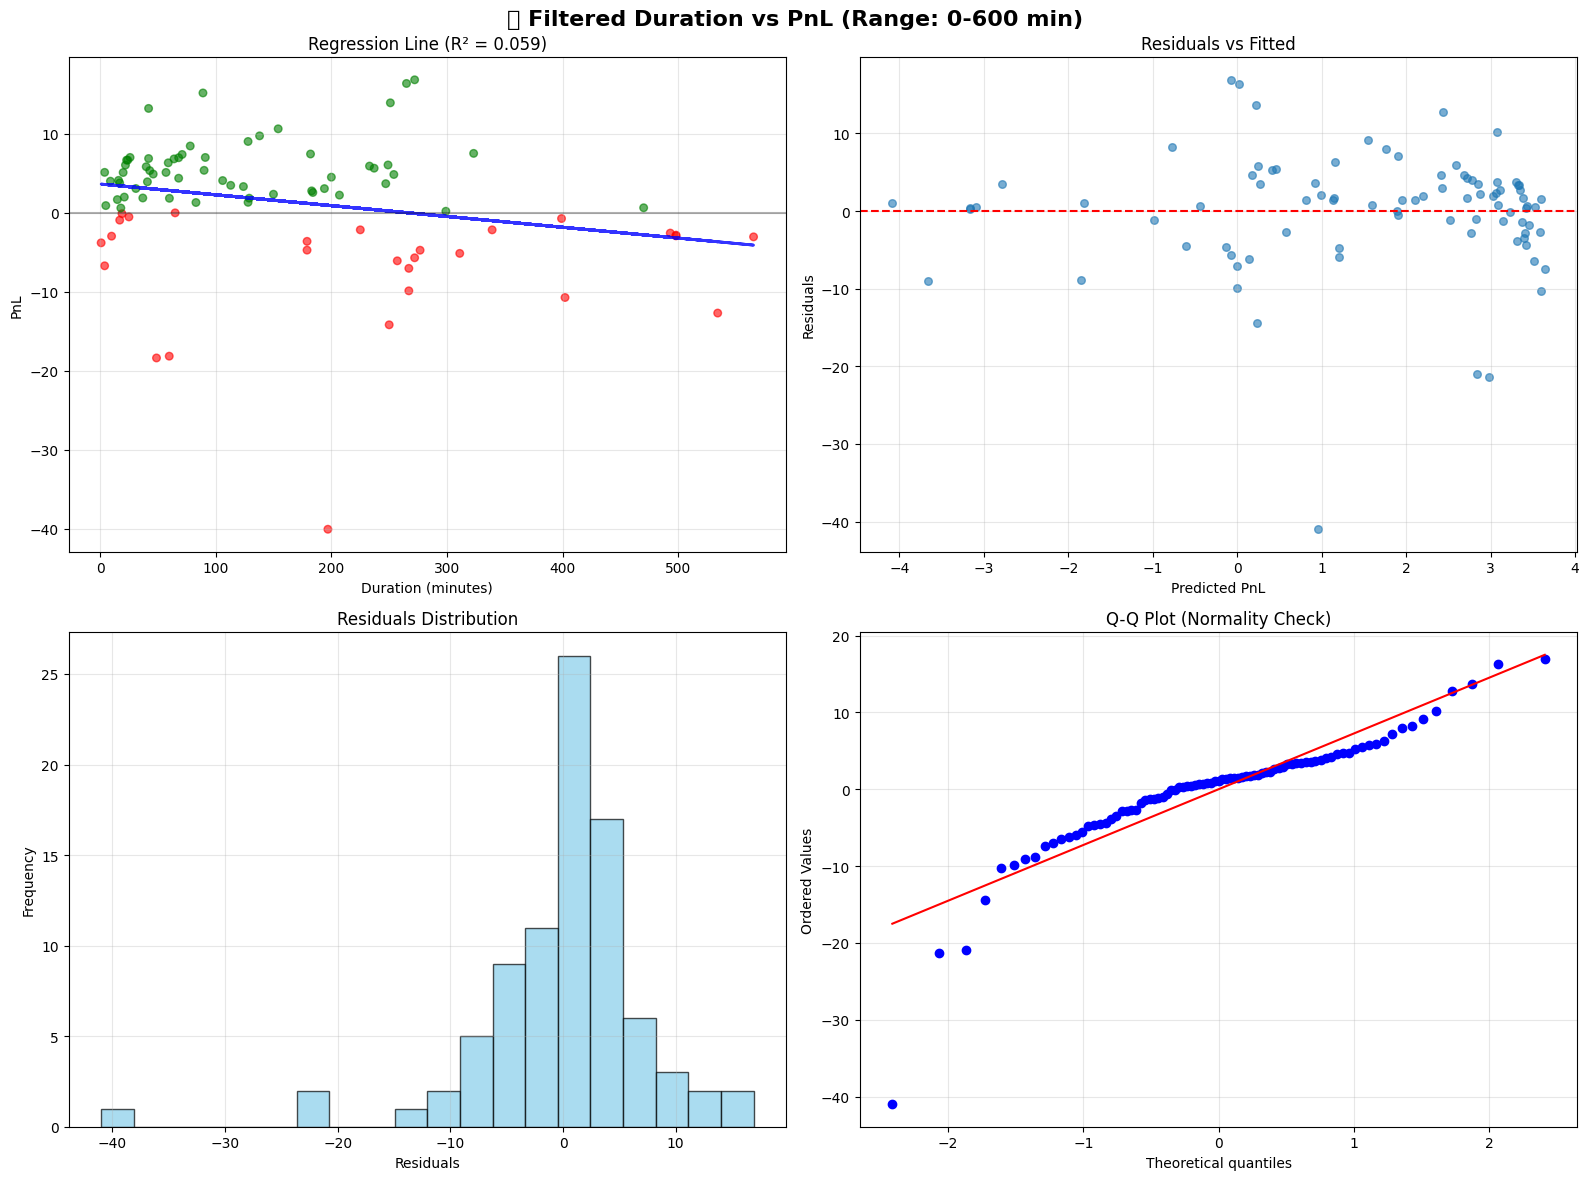

📊 FILTERED STATISTICS:
   📏 Mean Duration: 155.2 minutes
   📏 Median Duration: 113.0 minutes
   💰 Mean PnL: 1.529416
   💰 Median PnL: 3.070237
   📊 PnL Std Dev: 8.055544
   🎯 Win Rate: 67.8%


In [12]:
# Import required libraries for statistical analysis
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ========================================
# 🎯 FILTERED REGRESSION ANALYSIS
# ========================================

# 📋 Configure your duration range here (in minutes)
MIN_DURATION_MINUTES = 0      # Minimum duration to include
MAX_DURATION_MINUTES = 600   # Maximum duration to include (set to exclude outliers)

def analyze_duration_pnl_filtered(trades_df, min_duration=MIN_DURATION_MINUTES, max_duration=MAX_DURATION_MINUTES):
    """Perform regression analysis with custom duration filtering"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available for analysis")
        return
    
    # Prepare data
    trades_analysis = trades_df.copy()
    trades_analysis['duration_minutes'] = trades_analysis['duration'].dt.total_seconds() / 60
    
    # Apply duration filtering
    filtered_trades = trades_analysis[
        (trades_analysis['duration_minutes'] >= min_duration) & 
        (trades_analysis['duration_minutes'] <= max_duration)
    ].dropna(subset=['duration_minutes', 'pnl'])
    
    duration_data = filtered_trades['duration_minutes'].values.reshape(-1, 1)
    pnl_data = filtered_trades['pnl'].values
    
    print(f"🔍 FILTERED ANALYSIS (Duration: {min_duration}-{max_duration} minutes)")
    print(f"📊 Original Dataset: {len(trades_analysis)} trades")
    print(f"📊 Filtered Dataset: {len(filtered_trades)} trades ({len(filtered_trades)/len(trades_analysis)*100:.1f}%)")
    print(f"⏱️ Duration Range: {filtered_trades['duration_minutes'].min():.1f} - {filtered_trades['duration_minutes'].max():.1f} minutes")
    print(f"💰 PnL Range: {filtered_trades['pnl'].min():.6f} - {filtered_trades['pnl'].max():.6f}")
    print("-" * 60)
    
    # Correlation Analysis
    correlation, p_value = stats.pearsonr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    spearman_corr, spearman_p = stats.spearmanr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    
    print(f"🔗 Pearson Correlation: {correlation:.4f} (p={p_value:.2e})")
    print(f"🔄 Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
    print(f"🎯 Significance: {'Significant' if p_value < 0.05 else 'Not Significant'} (α=0.05)")
    print("-" * 60)
    
    # Linear Regression
    reg_model = LinearRegression()
    reg_model.fit(duration_data, pnl_data)
    pnl_predicted = reg_model.predict(duration_data)
    r2 = r2_score(pnl_data, pnl_predicted)
    
    slope = reg_model.coef_[0]
    intercept = reg_model.intercept_
    residuals = pnl_data - pnl_predicted
    
    print("📈 FILTERED REGRESSION RESULTS:")
    print(f"   📐 Slope (β₁): {slope:.8f} PnL per minute")
    print(f"   📍 Intercept (β₀): {intercept:.6f}")
    print(f"   📊 R²: {r2:.4f} ({r2*100:.2f}% variance explained)")
    
    if slope < 0:
        pnl_loss_per_hour = slope * 60
        print(f"   ⏰ PnL decreases by {abs(slope):.8f} per minute")
        print(f"   ⏰ PnL decreases by {abs(pnl_loss_per_hour):.6f} per hour")
    print("-" * 60)
    
    # Visual Analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=REGRESSION_FIGURES_SIZE)
    fig.suptitle(f'📊 Filtered Duration vs PnL (Range: {min_duration}-{max_duration} min)', fontsize=16, fontweight='bold')
    
    # Scatter plot with regression line
    ax1.scatter(filtered_trades['duration_minutes'], filtered_trades['pnl'], 
               alpha=0.6, c=['green' if p > 0 else 'red' for p in filtered_trades['pnl']], s=30)
    ax1.plot(filtered_trades['duration_minutes'], pnl_predicted, 'blue', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('PnL')
    ax1.set_title(f'Regression Line (R² = {r2:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', alpha=0.3)
    
    # Residuals plot
    ax2.scatter(pnl_predicted, residuals, alpha=0.6, s=30)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted PnL')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Fitted')
    ax2.grid(True, alpha=0.3)
    
    # Distribution of residuals
    ax3.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')
    ax3.grid(True, alpha=0.3)
    
    # QQ plot for normality check
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Statistics
    print(f"📊 FILTERED STATISTICS:")
    print(f"   📏 Mean Duration: {filtered_trades['duration_minutes'].mean():.1f} minutes")
    print(f"   📏 Median Duration: {filtered_trades['duration_minutes'].median():.1f} minutes")
    print(f"   💰 Mean PnL: {filtered_trades['pnl'].mean():.6f}")
    print(f"   💰 Median PnL: {filtered_trades['pnl'].median():.6f}")
    print(f"   📊 PnL Std Dev: {filtered_trades['pnl'].std():.6f}")
    print(f"   🎯 Win Rate: {(filtered_trades['pnl'] > 0).mean():.1%}")
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'slope': slope,
        'intercept': intercept,
        'r2': r2,
        'n_trades': len(filtered_trades),
        'filter_range': (min_duration, max_duration)
    }

# Execute filtered analysis
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    print("🎯 Running filtered regression analysis...")
    print(f"📋 Filter Range: {MIN_DURATION_MINUTES} - {MAX_DURATION_MINUTES} minutes")
    print("💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range")
    print("=" * 70)
    
    filtered_results = analyze_duration_pnl_filtered(trades_df_fast, MIN_DURATION_MINUTES, MAX_DURATION_MINUTES)
else:
    print("❌ No trades data available. Please run the backtest first.")